In [28]:
import pandas as pd
pd.options.mode.chained_assignment = None
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from datetime import datetime
import scipy as sp
from IPython.display import Image

# Look at data

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

## Train data

In [3]:
print('# of pairs:', '{:,}'.format(len(train)))
print('duplicate rate:', '{:.3f}'.format(len(train[train['is_duplicate'] == 1]) / len(train)))
train.head()

# of pairs: 404,290
duplicate rate: 0.369


,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


## Test data

In [4]:
print('# of pairs:', '{:,}'.format(len(test)))
test.head()

# of pairs: 2,345,796


,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


# Pre-processing

In [5]:
train['pair_id'] = train['id']
test['pair_id'] = test['test_id'] + len(train)

all_q = pd.DataFrame()
q_dict = {'train_q1': (train, 'question1'), 'train_q2': (train, 'question2'), 
          'test_q1': (test, 'question1'), 'test_q2': (test, 'question2')}
for q in q_dict:
    temp = q_dict[q][0].rename(columns={q_dict[q][1]: 'question'})[['pair_id', 'question']]
    temp['from'] = q_dict[q][1]
    all_q = pd.concat([all_q, temp])
all_q.loc[pd.isnull(all_q['question']), 'question'] = ''
all_q = all_q.sort_values(['pair_id', 'from']).reset_index(drop=True)

all_q.head()

,pair_id,question,from
0,0,What is the step by step guide to invest in sh...,question1
1,0,What is the step by step guide to invest in sh...,question2
2,1,What is the story of Kohinoor (Koh-i-Noor) Dia...,question1
3,1,What would happen if the Indian government sto...,question2
4,2,How can I increase the speed of my internet co...,question1


# TF-IDF
Reference: http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfVectorizer.html

In [6]:
questions = all_q['question']
tfidf_vectorizer = TfidfVectorizer()
tfidf_questions = tfidf_vectorizer.fit_transform(questions)

# Cosine similarity

In [9]:
cosine_sim = []
for i in range(int(len(all_q) / 2)):
    if i % 500000 == 0:
        print('pair#', '{:,}'.format(i), 'at', datetime.now())
    start_index = i*2
    tfidf_q1 = tfidf_questions[start_index: start_index+1]
    tfidf_q2 = tfidf_questions[start_index+1: start_index+2]
    cosine_sim.append(cosine_similarity(tfidf_q1, tfidf_q2)[0][0])

pair# 0 at 2017-03-19 18:44:59.887004
pair# 500,000 at 2017-03-19 18:56:57.997936
pair# 1,000,000 at 2017-03-19 19:08:55.873587
pair# 1,500,000 at 2017-03-19 19:20:54.607985
pair# 2,000,000 at 2017-03-19 19:32:54.187028
pair# 2,500,000 at 2017-03-19 19:44:52.362566


In [17]:
train['cosine_sim'] = cosine_sim[0: len(train)]
test['cosine_sim'] = cosine_sim[len(train):]

# Log loss on train data

In [25]:
def logloss(act, pred):
    epsilon = 1e-15
    pred = sp.maximum(epsilon, pred)
    pred = sp.minimum(1-epsilon, pred)
    ll = sum(act*sp.log(pred) + sp.subtract(1,act)*sp.log(sp.subtract(1,pred)))
    ll = ll * -1.0/len(act)
    return ll

logloss(train['is_duplicate'], train['cosine_sim'])

0.69145370149319774

# Submission

In [27]:
test[['test_id', 'cosine_sim']].rename(columns={'cosine_sim': 'is_duplicate'}).to_csv('submit_1.csv', index=False)

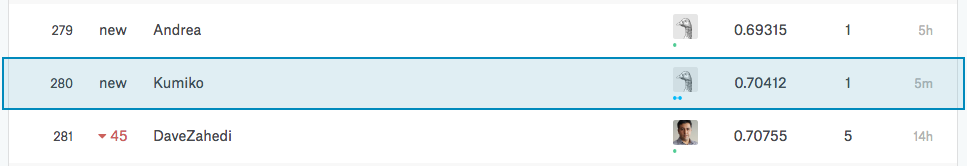

In [30]:
Image(filename='Screen Shot 2017-03-19 at 8.37.26 PM.png')